# Model Predictive Controller for Quadcopter Trajectory Tracking Based on Feedback Linearization

Project code by Apoorv Thapliyal

In this project, an MPC algorithm based on feedback linearization and model predictive control is devised to facilitate trajectory tracking for a quadcopter. The application of feedback linearization to the nonlinear model of the quadcopter results in a transformation, rendering the model linear. This linearized system serves as the basis for subsequent controller design. Leveraging feedback linearization allows the utilization of linear control schemes for quadcopter control. Subsequently, a model predictive controller is formulated for the linearized quadcopter model, initially overlooking external disturbances. To address external disturbances, a disturbance observer is developed to estimate these disturbances, ensuring the estimation error is bounded-input, bounded-output (BIBO) stable, thereby compensating for the impact of external disturbances. <br>

The simulation methodology follows a heirarchial format, it is recommended to open one section at a time using the drop down option next to the Headers.

Import libraries

In [2]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import rc
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#### Define Quadcopter parameters

In [3]:
Ix, Iy, Iz, Ip = 1.25, 1.25, 2.5, 5e-5
b, l, d = 2.5e-5, 0.25, 0.5e-6
m, g = 2, 9.8
d_wx, d_wy, d_wz = 0, 0, 0

# Define k, which is basically a very small value to ensure division by 0 never occurs
k = 1e-10

## 1. Dynamic Model of Quadcopter

### Define a function to Take U as i/p and get the angular velocity of propellers

In [4]:
def U2w(input):
  """
  Convert Control i/p U to propeller speed w
  if U < 0, then U = 0
  """
  input = Matrix([[max(0, elem) for elem in row] for row in input.tolist()])

  R = Matrix([[b, b, b, b],
              [1.414*l*b/2, -1.414*l*b/2, -1.414*l*b/2, 1.414*l*b/2],
              [1.414*l*b/2, 1.414*l*b/2, -1.414*l*b/2, -1.414*l*b/2],
              [d, -d, d, -d],
              ])

  w = R.solve(input).applyfunc(sqrt)

  return w


### Define a function to compute X_dot, call it dX_dt

In [5]:
def dX_dt(X, U):
  """
  Compute X_dot for a given state and Control i/p U
  """

  # U = Matrix([[max(0, elem) for elem in row] for row in U.tolist()])
  w = U2w(U)
  # print("U: ", U)
  # print("w: ", w)
  w_T = sum(w)
  #print(w_T, "\n")

  X_dot = Matrix([
      [X[3]],
      [X[4]],
      [X[5]],
      [-sin(X[7]) * U[0] / m + d_wx],
      [sin(X[6]) * cos(X[7]) * U[0] / m + d_wy],
      [cos(X[6]) * cos(X[7]) * U[0] / m + d_wz - g],
      [cos(X[8]) * X[9] - sin(X[8]) *X[10]],
      [sin(X[8]) * X[9] + cos(X[8]) * X[10]],
      [X[11]],
      [1/Ix * ((Iy-Iz) * X[10] * X[11] - Ip*X[10] * w_T + U[1])],
      [1/Iy * ((Iz-Ix) * X[9] * X[11] - Ip*X[9] * w_T + U[2])],
      [1/Iz * ((Ix-Iy) * X[9] * X[10] + U[3])]
      ])

  # print("X_dot.T: ", X_dot.T)
  return X_dot

### Give an i/p equal to drone weight to verify the model

In [6]:
X_verify = Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).T
d_wx, d_wy, d_wz = 0, 0, 0
k = 1e-10
U_verify = Matrix([[m*g], [k], [k], [k]])

for i in range(0, 10):
  X_dot = dX_dt(X_verify, U_verify)
  X_verify += X_dot * 0.1
  print("z: ", X_verify[2], "\n")
  # print("x: ", X_verify[0], "\n")

z:  0 

z:  0 

z:  0 

z:  0 

z:  0 

z:  0 

z:  0 

z:  0 

z:  0 

z:  0 



## 2. Add a PID Controller to this model

This section is strictly for verification of the drone model and has no relation to the actual output of the paper

In [ ]:
U = Matrix([[0], [0], [0], [0]])
X = Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).T

z = []
t = []
error_list = []
kp_list = []
U_list = []
kp = 10.5 # 10
kd = 7.3# 7
ki = 0.8 # 1
z_des = 1
dt = 0.1
error_prev = 0
e_dot = 0
e_int = 0
force_coeff = 2
X_dot = dX_dt(X, U)

for i in range(0, 100):

  # State update
  X += X_dot * dt
  X_dot = dX_dt(X, U)

  error = z_des - X[2]

  e_int += error
  # e_int has to be capped so that the integral component doesnt increase too high above max w
  e_int = min(force_coeff*m*g/ki, e_int)
  e_dot = (error-error_prev)/dt

  U0 = kp * error + kd * e_dot + ki * e_int

  U0 = min(force_coeff*m*g, U0)
  # U = Matrix([[Uz], [0], [0], [0]])
  # w = angular_speed(U)

  U = Matrix([U0, 0, 0, 0])
  U = Matrix([[max(0, elem) for elem in row] for row in U.tolist()])

  error_prev = error

  print("t: ", i*dt)
  # print('kp*error: ',kp*error)
  # print('kd*e_dot: ',kd*e_dot)
  # print('ki*e_int: ',ki*e_int)
  # print("U0:", U[0])
  # print("z: ", X[2])
  # print("error: ", error)
  # print("Xdot: ",X_dot)
  # print("X: ", X)
  # print("z_dot, z_ddot: ", X_dot[2], X_dot[5])
  print("z, z_dot: ", X[2], X[5])
  print("\n")
  U_list.append(U0)
  kp_list.append(kp*error)
  z.append(X[2])
  t.append(i*dt)
  error_list.append(error)

# Create a line plot
plt.plot(t, z, label="z")
# plt.plot(t, error_list, label="error")
#plt.plot(t, kp_list, label="kp*error")
# plt.plot(t, w_list, label="w")
# Add labels and title
plt.xlabel("t")
plt.ylabel("z")
plt.axhline(y=1, color='r', linestyle='--', label='z_des')
plt.title("Line Plot of z")

# Display the plot
plt.legend()
plt.grid()
plt.show()

U = Matrix([[0], [0], [0], [0]])
X = Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).T

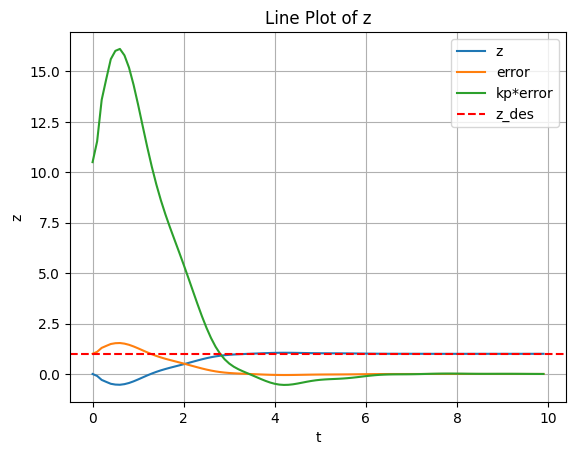

In [8]:
# Create a line plot
plt.plot(t, z, label="z")
plt.plot(t, error_list, label="error")
plt.plot(t, kp_list, label="kp*error")
# plt.plot(t, U_list, label="U")
# Add labels and title
plt.xlabel("t")
plt.ylabel("z")
plt.axhline(y=1, color='r', linestyle='--', label='z_des')
plt.title("Line Plot of z")

# Display the plot
plt.legend()
plt.grid()
plt.show()

## 3. Linearize the model

We will use the following model to simulate our quadcopter: <br>
V = a(X) + b(X) * U $\quad\quad$ (10) <br>
W = h(X) $\quad\quad$ (12) <br>
W_dot = A * W + B * V $\quad\quad$ (15) <br>
Y = C * W

We have a new i/p, U1_dot, set it as 0 for now and update it within our loops

In [ ]:
k = 1e-10
U1_dot = k

### Calculate a(X)

In [ ]:
def a_X(X, U1, U1_dot):
  """
  NOTE: Only send U[0] and U_dot[0]
  """

  phi = X[6]
  theta = X[7]
  psi = X[8]

  phi_dot = cos(psi) * X[9] - sin(psi) * X[10]
  theta_dot = sin(psi) * X[9] + cos(psi) * X[10]
  psi_dot = X[11]

  U1_m = U1/m
  U1_dot_m = U1_dot/m


  a1 = theta_dot**2 * sin(theta) * U1_m - 2 * theta_dot * cos(theta) * U1_dot_m

  a2 =  -(phi_dot**2 + theta_dot**2) * sin(phi) * cos(theta) * U1_m - 2 * phi_dot * theta_dot * cos(phi) * sin(theta) * U1_m
  + 2 * (phi_dot * cos(phi) * cos(theta) * U1_dot_m - theta_dot * sin(phi) * sin(theta) * U1_dot_m)

  a3 = -(phi_dot**2 + theta_dot**2) * cos(phi) * cos(theta) * U1_m + 2 * phi_dot * theta_dot * sin(phi) * sin(theta) * U1_m
  -2 * (phi_dot * sin(phi) * cos(theta) * U1_dot_m + theta_dot * cos(phi) * sin(theta) * U1_dot_m)

  return Matrix([[ a1 ],
                 [ a2 ],
                 [ a3 ],
                 [ 0 ]])

# To verify
X_verify = Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).T
U_verify = Matrix([[0], [0], [0], [0]])
a_X(X_verify, U_verify[0] ,U1_dot)

### Calculate b(X)

In [ ]:
def b_X(X, U1):
  """
  NOTE: Only send U[0]
  """

  phi = X[6]
  theta = X[7]
  psi = X[8]

  U1_m  = U1/m

  b11 = -sin(theta)/m
  b12 = -cos(theta) * sin(phi) * U1_m / (Ix)
  b13 = -cos(theta) * cos(phi) * U1_m / (Iy)
  b14 = 0

  b21 = sin(phi) * cos(theta) / m
  b22 = (cos(phi) * cos(theta) * cos(psi) - sin(phi)*sin(theta)*sin(psi)) * U1_m / (Ix)
  b23 = -(cos(phi) * cos(theta) * sin(psi) - sin(phi)*sin(theta)*cos(psi)) * U1_m / (Iy)
  b24 = 0

  b31 = cos(phi) * cos(theta) / m
  b32 = -(sin(phi) * cos(theta) * cos(psi) + cos(phi)*sin(theta)*sin(psi)) * U1_m / (Ix)
  b33 = (sin(phi) * cos(theta) * sin(psi) - cos(phi)*sin(theta)*cos(psi)) * U1_m / (Iy)
  b34 = 0

  b41, b42, b43 = 0, 0, 0
  b44 = 1/Iz

  return Matrix([[b11, b12, b13, b14],
                 [b21, b22, b23, b24],
                 [b31, b32, b33, b34],
                 [b41, b42, b43, b44]])

# To verify
X_verify = Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).T
U_verify = Matrix([[0], [0], [0], [0]])
b_X(X_verify, U_verify[0])

### Calculate h(X)

In [ ]:
def h(X, U, U1_dot):
  """
  NOTE: Only send U[0] and U_dot[0]
  Transforms nonlinear state X to linear state W
  """

  dx_dt = dX_dt(X, U)
  phi = X[6]
  theta = X[7]
  psi = X[8]

  phi_dot = cos(psi) * X[9] - sin(psi) * X[10]
  theta_dot = sin(psi) * X[9] + cos(psi) * X[10]
  psi_dot = X[11]

  U1_m = U[0]/m
  U1_dot_m = U1_dot/m

  return Matrix([ [ X[0] ],
                  [ dx_dt[0] ],
                  [ - sin(theta)*U1_m ],
                  [ -theta_dot * cos(theta) * U1_m - sin(theta) * U1_dot_m ],
                  [ X[1] ],
                  [ dx_dt[1] ],
                  [ sin(phi * cos(theta) * U1_m) ],
                  [ phi_dot * cos(phi) * cos(theta) * U1_m - theta_dot * sin(phi) * sin(theta) * U1_m + sin(phi) * cos(theta) * U1_dot_m],
                  [ X[2] ],
                  [ dx_dt[2] ],
                  [ cos(phi) * cos(theta) * U1_m - g ],
                  [ -phi_dot * sin(phi) * cos(theta) * U1_m - theta_dot * cos(phi) * sin(theta) * U1_m + cos(phi) * cos(theta) * U1_dot_m ],
                  [ psi ],
                  [ X[11] ],
                 ])

X_verify = Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).T
U_verify = Matrix([[0], [0], [0], [0]])
h(X_verify, U_verify, U1_dot)

### Calculate hinv to get X back from W

In [ ]:
def hinv(w, U1, U1_dot):
  """
  NOTE: Send only U[0] and U1_dot
  Transforms linear state W to nonlinear state X
  """
  theta = asin(-m / U1 * w[2])
  phi = asin(m / (U1 * cos(theta)) * w[6])
  # phi = acos( (g + w[10]) * m / (U1 * cos(theta) ) )
  psi = w[12]

  theta_dot = -(w[3] + sin(theta) * U1_dot/m) * m / (U1 * cos(theta))
  phi_dot = (w[7] + theta_dot * sin(phi) * sin(theta) * U1/m - sin(phi) * cos(theta) * U1_dot/m) * m/(U1 * cos(theta) * cos(phi))

  p = phi_dot * cos(psi) + theta_dot * sin(psi)
  q = theta_dot * cos(psi) - phi_dot * sin(psi)

  return Matrix([[w[0]],
                 [w[4]],
                 [w[8]],
                 [w[1]],
                 [w[5]],
                 [w[9]],
                 [phi],
                 [theta],
                 [w[12]],
                 [p],
                 [q],
                 [w[13]]])

### Define A, B, C Matrices

In [ ]:
A1 = Matrix([[0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1],
             [0, 0, 0, 0]])
A2 = Matrix([[0, 1],
             [0, 0]])

o_4x4 = zeros(4, 4)
o_2x4 = zeros(2, 4)
o_4x2 = zeros(4, 2)

A11 = A1.row_join(o_4x4)
A11 = A11.row_join(o_4x4)
A11 = A11.row_join(o_4x2)

A12 = o_4x4.row_join(A1)
A12 = A12.row_join(o_4x4)
A12 = A12.row_join(o_4x2)

A13 = o_4x4.row_join(o_4x4)
A13 = A13.row_join(A1)
A13 = A13.row_join(o_4x2)

A14 = o_2x4.row_join(o_2x4)
A14 = A14.row_join(o_2x4)
A14 = A14.row_join(A2)

A = A11.col_join(A12)
A = A.col_join(A13)
A = A.col_join(A14)

B = Matrix([[0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [1, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 1],])

C = Matrix([[1, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0],]).T

A
# B
# C

### Simulate the model

Simulate the model by giving U = 0 input, ideally the quadcopter should fall -4.41m with gravity within 1 second

In [ ]:
# Define the initial states
k = 1e-10
X = Matrix([[k, k, k, k, k, k, k, k, k, k, k, k]]).T
U = Matrix([[k], [k], [k], [k]])
U1_dot = k
dt = 0.1

# Create empty lists to store Y[2] and V[2] values
Y2_values = []
V2_values = []
t = []


for i in range(0, 10):
  print("i: ", i)

  ############################ PRIMARY COMPUTATION #############################
  # Calculate a(X) and b(X)
  aX = a_X(X, U[0], U1_dot)
  bX = b_X(X, U[0])

  # Calculate new output V
  V = aX + bX * U
  # print("V: ", V)

  # Convert to new state W
  W = h(X, U, U1_dot)
  # print("W[8:12]: ", W[8:12])

  # Calculate W_dot
  W_dot = A * W + B * V
  # print("W_dot[8:12]: ", W_dot[8:12])

  # Discretized model
  W += W_dot * dt

  # Calculate output
  Y = C * W
  print("Y: ", Y)

  # Get X back from W
  X = hinv(W, U[0], U1_dot)
  # print("X: ", X)
  ##############################################################################

  print("\n")

  # Append Y[2] and V[2] values to the lists
  Y2_values.append(Y[2])
  V2_values.append(V[2])
  t.append([i*dt])

# After the loop, plot the values of Y[2] and V[2]
plt.figure()
plt.plot(t, Y2_values, label="Y[2]")
plt.plot(t, V2_values, label="V[2]")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Y[2] and V[2] vs. Iteration")
plt.legend()
plt.grid()
plt.show()

### Define 2 matrices Abar and Bbar



This will be used for the discrete model of the quadcopter <br>
W (k + 1|k) = (I + TA) W (k) + TBV (k) <br>
W (k + 1) = A¯W (k) + B¯V (k) <br>
A¯ = (I + TA) and B¯ = TB

In [ ]:
Abar = eye(A.shape[0]) + dt * A
Bbar = dt * B

### Discritize the model

Simulate the discritized model by giving U = 0 input, ideally the quadcopter should fall -4.41m with gravity within 1 second. <br>
Giving U1 = m*g, it can be seen that the quadcopter holds its initial position

In [ ]:
# Define the initial states
k = 1e-10
X = Matrix([[k, k, k, k, k, k, k, k, k, k, k, k]]).T
U = Matrix([[k], [k], [k], [k]])
U1_dot = k
U1_prev = U[0]
dt = 0.1

# Create empty lists to store Y[2] and V[2] values
Y2_values = []
V2_values = []
t = []

W = h(X, U, U1_dot)

aX = a_X(X, U[0], U1_dot)
bX = b_X(X, U[0])

# Calculate new output V
V = aX + bX * U
V = zeros(4, 1)

for i in range(0, 10):
  print("i: ", i)

  ############################ PRIMARY COMPUTATION #############################
  # Calculate a(X) and b(X)
  aX = a_X(X, U[0], U1_dot)
  bX = b_X(X, U[0])

  # Calculate new output V
  V = aX + bX * U
  print("V: ", V)

  # Convert to new state W
  W = h(X, U, U1_dot)
  # print("W[8:12]: ", W[8:12])

  # Calculate next W
  W = Abar * W + Bbar * V
  # Wdot = A*W +B*V
  # W += Wdot * dt

  # print("W_dot[8:12]: ", W_dot[8:12])

  # Calculate output
  Y = C * W
  print("Y: ", Y)

  # Get X back from W
  X = hinv(W, U[0], U1_dot)
  # print("X: ", X)

  # Calculate U_dot, add k so that U_dot =/= 0
  U1_dot = ((U[0] - U1_prev) / dt) + k
  U1_prev = U[0]
  print("U1_dot: ", U1_dot)
  ##############################################################################

  print("\n")

  # Append Y[2] and V[2] values to the lists
  Y2_values.append(Y[2])
  V2_values.append(V[2])
  t.append([i*dt])

# After the loop, plot the values of Y[2] and V[2]
plt.figure()
plt.plot(t, Y2_values, label="Y[2]")
plt.plot(t, V2_values, label="V[2]")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Y[2] and V[2] vs. Iteration")
plt.legend()
plt.grid()
plt.show()

And thus we get a working model of the quadcopter with feedback linearization

### Discretized model with V as i/p
So far we have been giving U as our i/p and simulating the model accordingly, but for MPC our i/p will be V. So we will now try to give V as an i/p and define functions and methods accordingly

In [ ]:
def V2U(V, ax, bx):
    bx_inv = bx.inv()
    return bx_inv * (V - ax)

### Calculate U given some V

In [ ]:
# Define the initial states
k = 1e-10
X = Matrix([[k, k, k, k, k, k, k, k, k, k, k, k]]).T
U = Matrix([[m*g], [k], [k], [k]])

U1_dot = k
U1_prev = U[0]
dt = 0.1

# Calculate equivalent V
ax = a_X(X, U[0], U1_dot)
bx = b_X(X, U[0])
V = ax + bx * U
print("********** INITIAL CONDITIONS ************\n")
print("U: ", U)
print("V: ", V)
print("\n***************************************\n")

# Create empty lists to store Y[2] and V[2] values
Y3_values = []
V3_values = []
Y2_values = []
V2_values = []
Y0_values = []
Y1_values = []
V0_values = []
V1_values = []
t = []


for i in range(0, 10):
  print("i: ", i)

  ############################ PRIMARY COMPUTATION #############################

  # Calculate a(X) and b(X)
  aX = a_X(X, U[0], U1_dot)
  bX = b_X(X, U[0])

  # Calculate U, given V
  U = V2U(V, aX, bX)
  print("U: ", U)

  # Calculate output V for every U to see if it remains the same or changes
  V_verify = aX + bX * U
  print("V_verify: ", V_verify)

  # Convert to new state W
  W = h(X, U, U1_dot)
  # print("W[8:12]: ", W[8:12])

  # Calculate next W
  W = (eye(W.shape[0]) + dt * A) * W + dt * B * V
  # print("W_dot[8:12]: ", W_dot[8:12])

  # Calculate output
  Y = C * W
  print("Y: ", Y)

  # Get X back from W
  X = hinv(W, U[0], U1_dot)
  # print("X: ", X)

  # Calculate U_dot, add k so that U_dot =/= 0
  U1_dot = ((U[0] - U1_prev) / dt) + k
  U1_prev = U[0]
  print("U1_dot: ", U1_dot)
  ##############################################################################

  print("\n")

  # Append Y[2] and V[2] values to the lists
  Y3_values.append(Y[3])
  V3_values.append(V[3])
  Y2_values.append(Y[2])
  V2_values.append(V[2])
  Y0_values.append(Y[0])
  Y1_values.append(Y[1])
  V0_values.append(V[0])
  V1_values.append(V[1])
  t.append([i*dt])

# After the loop, plot the values of Y[2], Y[0], Y[1], Y[3], V[2], V[0], V[1], and V[3]
plt.figure(figsize=(12, 8))

# Plot Y[2] and V[2]
plt.subplot(3, 2, 1)
plt.plot(t, Y2_values, label="z")
plt.plot(t, V2_values, label="V[2]")
plt.xlabel("time")
plt.ylabel("Value")
plt.title("z and V[2] vs. Iteration")
plt.legend()
plt.grid()

# Plot Y[0] and V[0]
plt.subplot(3, 2, 2)
plt.plot(t, Y0_values, label="x")
plt.plot(t, V0_values, label="V[0]")
plt.xlabel("time")
plt.ylabel("Value")
plt.title("x and V[0] vs. Iteration")
plt.legend()
plt.grid()

# Plot Y[1] and V[1]
plt.subplot(3, 2, 3)
plt.plot(t, Y1_values, label="y")
plt.plot(t, V1_values, label="V[1]")
plt.xlabel("time")
plt.ylabel("Value")
plt.title("Y[1] and V[1] vs. Iteration")
plt.legend()
plt.grid()

# Plot Y[3] and V[3]
plt.subplot(3, 2, 4)
plt.plot(t, Y3_values, label="yaw")
plt.plot(t, V3_values, label="V[3]")
plt.xlabel("time")
plt.ylabel("Value")
plt.title("Y[3] and V[3] vs. Iteration")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

With these figures, we are able to control the quadcopter for a certain input V. The x, y, z, yaw values remain 0 for the control input U1 = mg, U2 = 0, U3 = 0, U4 = 0

## 4. Model Predictive Control

### Define few variables

In [ ]:
p = 10 # prediction horizon

Q = 10 * eye(14*p) # Weight for tracking error

F = 0.01 * eye(4*p) # Weight for control input

### Define prediction matrices A2 and B2

As per equation (20):
Wp = $𝚿$ * W(k) + $𝚯$ * Vk <br>
Where, <br>
Wp is the next 10 predicted states, is W(k+1), W(k+2)... W(k+p)  <br>
W(k) is current state <br>
V(k) is the input applied at each time step k to k_p-1 <br>

Let $𝚿$ = A2 and $𝚯$ = B2, thus: <br>
Wp = A2 * W(k) + B2 * Vk <br>

In [ ]:
A2 = Abar
for i in range(2, 11):
  Ai = Abar**i
  # print(Ai)
  A2 = A2.col_join(Ai)

# A2

In [ ]:
B2 = Matrix(([]))
o_14x4 = zeros(14, 4)


for j in range(1, p+1):
  Bcol = Matrix(([]))
  for i in range(1, p+1):
    if(i <= j-1):
      Bcol = Bcol.col_join(o_14x4)
    else:
      Bcol = Bcol.col_join( Abar**(i-j) * Bbar )

  B2 = B2.row_join(Bcol)

# B2

### Predict next 10 steps

Give Vk as 0 and some initial states to verify the working of the prediction matrices. <br>
Wp = A2 * W(k) + B2 * Vk

In [ ]:
k = 1e-10
X_verify = Matrix([[k, k, k, k, k, k, k, k, k, k, k, k]]).T
U_verify = Matrix([[m*g], [k], [k], [k]])
U1_dot = k
U1_prev = U[0]
dt = 0.1

W_verify = h(X_verify, U_verify, U1_dot)
Vk = zeros(4*10, 1)

Wp = A2 * W_verify + B2 * Vk
# W_p = W_verify.T * A2.T + Vk.T * B2.T

Wp

### Generate a Reference Trajectory

Using the np.tile function, we can use the W_desired state to make our Rk matrix <br>
Basically, we just feed the desired position as our reference trajectory for the next 10 time steps

In [ ]:
X_des = Matrix([[6, 8, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
U_des = Matrix([[m*g], [k], [k], [k]])
W_des = h(X_des, U_des,  U1_dot)

Rk = Matrix(np.tile(W_des, (10, 1)))
Rk

### Optimizer Parameters

Define some parameters like Vmax and Vmin

In [ ]:
Vmax = np.array([1, 0.05, 0.05, 0.05])
# Vmax = np.array([1, 1, 1, 1])
desired_size = 40
Vmax = np.tile(Vmax, desired_size // len(Vmax) + 1)[:desired_size]
Vmax = np.reshape(Vmax, (40, 1))

Vmin = np.array([-1, -0.05, -0.05, -0.05])
# Vmin = np.array([-1, -1, -1, -1])
desired_size = 40
Vmin = np.tile(Vmin, desired_size // len(Vmin) + 1)[:desired_size]
Vmin = np.reshape(Vmin, (40, 1))

# Vmin

### Main Optimizer

Formulate the control problem, define J and minimize it over a single iteration to see if it works

Initial conditions for testing

In [ ]:
X_curr = Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
U_verify = Matrix([[m*g], [k], [k], [k]])
U1_dot = k
W_curr = h(X_curr, U_verify, U1_dot)

X_des = Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
U_des = Matrix([[m*g], [k], [k], [k]])
U1_dot = k
W_des = h(X_des, U_des,  U1_dot)

Rk = Matrix(np.tile(W_des, (10, 1)))

Make the data types suitable

In [ ]:
A2_num = np.array(A2).astype('float64')
B2_num = np.array(B2).astype('float64')
W_curr_num = np.array(W_curr)
W_curr_num.astype('float64')

array([[0.e+00],
       [0.e+00],
       [0.e+00],
       [0.e+00],
       [0.e+00],
       [0.e+00],
       [0.e+00],
       [0.e+00],
       [0.e+00],
       [0.e+00],
       [0.e+00],
       [5.e-11],
       [0.e+00],
       [0.e+00]])

We can define our optimizer something like this

In [ ]:
Vp = cvx.Variable((40,1)) # Give 0 input for next 10 timesteps
W_p = cvx.Variable((140,1))
J = cvx.quad_form((W_p - Rk), Q) + cvx.quad_form(Vp,F)
constaints = [W_p == A2_num @ W_curr_num + B2_num @ Vp,
              Vmin <= Vp,
              Vp <= Vmax]
opt_prob = cvx.Problem(cvx.Minimize(J),constaints)
opt_prob.solve()

Vp.value

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [-2.09011199e-10],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-4.04698514e-12],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.55561605e-11],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.96501683e-11],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 2.24999935e-11],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 2.53025783e-11],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 2.81559464e-11],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 3.10493088e-11],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 3.37647974e-11],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 3.3

In [ ]:
V_k = Matrix([[ float(Vp.value[0])],
              [ float(Vp.value[1])],
              [ float(Vp.value[2])],
              [ float(Vp.value[3])]])

W_curr= Abar * W_curr + Bbar * V_k
W_curr

Matrix([
[                   0],
[                   0],
[                   0],
[                   0],
[                   0],
[                   0],
[                   0],
[                   0],
[                   0],
[                   0],
[             5.0e-12],
[2.90988801270734e-11],
[                   0],
[                   0]])

With this we can confirm the functionality of our Optimizer. <br>
We can now use this for our MPC controller in the Test Scenarios

## 5. Disturbance Observer

### Define relevant matrices

Define Bd, the coefficient matrix of the disturbance vector

In [ ]:
Bd = Matrix([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]).T

Bd

Matrix([
[0, 0, 0],
[1, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 1, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 1],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

Define Bd_param, which is Bd repeated 10 times to make it a 140x3 matrix. <br>
We need this for the optimization constraint

In [ ]:
Bd_param = np.tile(Bd, (10, 1))

# Bd_param

Set Disturbance Observer gain: L

In [ ]:
L = Matrix([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

### Wind Disturbance

Define the Wind Disturbance matrix <br>
Their values will be changed every Test Scenario <br>

In [ ]:
d_wx, d_wy, d_wz = 0.12, -0.08, 0.05
disturbance = Matrix([[d_wx],
            [d_wy],
            [d_wz]])

disturbance

Matrix([
[ 0.12],
[-0.08],
[ 0.05]])

Thus the final model with disturbance would be: <br>
W (k + 1) = A¯*W(k) + B¯*V(k) + Bd_dt*d<br>
A¯ = (I + TA) , B¯ = TB and d is the disturbance matrix<br>



We use the following equations to form our distance observer in discrete form: <br>
gamma_dot(k) = -L*Bd*(gamma(k-1) + L*W(k)) - L(A*W(k) + B*V(k)) <br>
d_hat = gamma(k-1) + dt*gamma_dot(k) + L*W <br>

Any variable with the notation _do is a variable with the disturbance observer term accounted for

## TEST SCENARIO I: WAYPOINT TRACKING


In this scenario, the desired waypoint is set to (x: 6, y: 8, z: 10, yaw: 0).<br>
The simulation lasts 100 seconds. <br>
This section is divided into 3 parts. Part 1 deals with no wind disturbance to show the MPC control in an ideal situation. Part 2 adds a constant wind disturbance, while Part 3 adds superposed sine waves as wind disturbance. <br>
Part 2 and Part 3 are relevant to the paper used.

In [ ]:
# Define total simulation time,  = iterations * dt
iterations = 1000

### PART 1
Initial position: Quadcopter hovering at the origin <br>
Final position: Quadcopter hovering at the position (x: 6, y: 8, z: 10, yaw: 0) <br>
No wind disturbance, ie d_wx = d_wy = d_wz = 0.0

In [ ]:
##### Initial State
X_curr = Matrix([k, k, k, k, k, k, k, k, k, k, k, k])
U_curr = Matrix([m*g, k, k, k])
U1_dot = k
W_curr = h(X_curr, U_curr, U1_dot)

##### Desired State
X_des = Matrix([[6, 8, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
U_des = Matrix([[m*g], [k], [k], [k]])
W_des = h(X_des, U_des,  U1_dot)

Rk = Matrix(np.tile(W_des, (10, 1)))

##### Disturbance Observer
W_do = W_curr
d_wx, d_wy, d_wz = 0.0, 0.0, 0.0

disturbance = Matrix([[d_wx],
                      [d_wy],
                      [d_wz]])
# disturbance_num = np.array(disturbance)
gamma_k = Matrix(zeros(3, 1))
gamma_k_1 = Matrix(zeros(3, 1))
gamma_dot = Matrix(zeros(3, 1))
d_hat = Matrix(zeros(3, 1))

# Optimization variables
Vp = cvx.Variable((40,1))
W_p = cvx.Variable((140,1))

##### States for plotting
x, y, z = [], [], []
x_do, y_do, z_do = [], [], []
d_x, d_y, d_z = [], [], []
t = []

for i in range(iterations):
  print("i: ", i)

  ############################# PRIMARY COMPUTATION ############################

  ############### OPTIMIZATION ###############
  # Define optimization variables
  W_curr_num = np.array(W_curr)
  W_curr_num.astype('float64')

  # Get the optimized inputs Vk for the given reference trajectory Rk
  J = cvx.quad_form((W_p - Rk), Q) + cvx.quad_form(Vp,F)
  constaints = [W_p == A2_num @ W_curr_num + B2_num @ Vp + Bd_param @ np.array(d_hat * dt),
                Vmin <= Vp,
                Vp <= Vmax]
  opt_prob = cvx.Problem(cvx.Minimize(J),constaints)
  opt_prob.solve()

  # Take the first 4 elements of Vp as our current input Vk
  Vk = Matrix([[float(Vp.value[0])], [float(Vp.value[1])], [float(Vp.value[2])], [float(Vp.value[3])]])
  ############################################

  ############### DISTURBANCE OBSERVER ###############
  gamma_dot = -L * Bd * (gamma_k_1 + L * W_curr) - L * (A * W_curr + B * Vk)

  d_hat = gamma_k_1 + dt * gamma_dot + L * W_curr

  # Update gamma
  gamma_k_1 = gamma_k
  gamma_k += gamma_dot * dt
  ####################################################


  ############### UPDATE THE MODEL ###############
  # Update our model
  W_curr = Abar * W_curr + Bbar * Vk + Bd * dt * disturbance

  # Get the output matrix
  Y = C * W_curr

  # Update our disturbance observer model
  W_do = Abar * W_curr + Bbar * Vk - Bd * dt * d_hat

  # Get the output disturbance observer matrix
  Y_do = C * W_do
  ###############################################


  ##############################################################################

  x.append(Y[0]), y.append(Y[1]), z.append(Y[2])
  x_do.append(Y_do[0]), y_do.append(Y_do[1]), z_do.append(Y_do[2])
  d_x.append(d_hat[0]), d_y.append(d_hat[1]), d_z.append(d_hat[2])
  t.append([i*dt])

  #Print values
  print("Rk: ", Rk)
  print("W_curr: ", W_curr)
  print("Y: ", Y)
  print("Vk: ", Vk)
  print("gamma_dot: ", gamma_dot)
  print("d_hat: ", d_hat)
  print("Y_do: ", Y_do)
  print("\n")


# Create subplots for position and disturbance
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot for x, y, z in the first column
axs[0, 0].plot(t, x, label="x", linestyle="-.", color="red")
axs[0, 0].plot(t, x_do, label="x_do", linestyle="--", color="darkblue")
axs[0, 0].set_ylabel("X (m)")
axs[0, 0].axhline(y=X_des[0], color='black', label='Reference')
axs[0, 0].legend()
axs[0, 0].grid()

axs[1, 0].plot(t, y, label="y", linestyle="-.", color="red")
axs[1, 0].plot(t, y_do, label="y_do", linestyle="--", color="darkblue")
axs[1, 0].set_ylabel("Y (m)")
axs[1, 0].axhline(y=X_des[1], color='black', label='Reference')
axs[1, 0].legend()
axs[1, 0].grid()

axs[2, 0].plot(t, z, label="z", linestyle="-.", color="red")
axs[2, 0].plot(t, z_do, label="z_do", linestyle="--", color="darkblue")
axs[2, 0].set_ylabel("Z (m)")
axs[2, 0].axhline(y=X_des[2], color='black', label='Reference')
axs[2, 0].legend()
axs[2, 0].grid()

# Plot for d_x, d_y, d_z in the second column
axs[0, 1].plot(t, d_x, color='darkblue', linestyle='--', label="d_x")
axs[0, 1].set_ylabel("X (m/s^2)")
axs[0, 1].axhline(y=d_wx, color='black', label='Reference')
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 1].plot(t, d_y, color='darkblue', linestyle='--', label="d_y")
axs[1, 1].set_ylabel("Y (m/s^2)")
axs[1, 1].axhline(y=d_wy, color='black', label='Reference')
axs[1, 1].legend()
axs[1, 1].grid()

axs[2, 1].plot(t, d_z, color='darkblue', linestyle='--', label="d_z")
axs[2, 1].set_xlabel("t")
axs[2, 1].set_ylabel("Z (m/s^2)")
axs[2, 1].axhline(y=d_wz, color='black', label='Reference')
axs[2, 1].legend()
axs[2, 1].grid()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


#### Visualization of the trajectory

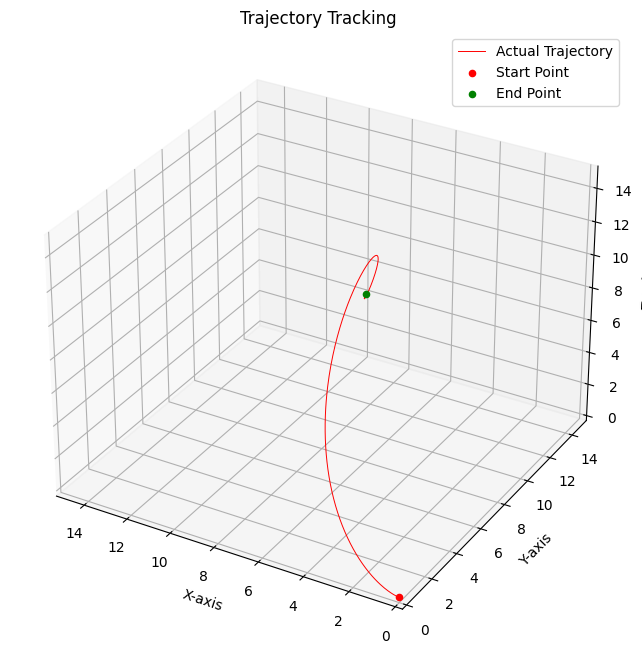

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Actual Trajectory', color='red', linewidth=0.7)
ax.scatter(0, 0, 0, color='red', label='Start Point')
ax.scatter(x[-1], y[-1], z[-1], color='green', label='End Point')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectory Tracking')
ax.legend()

ax.set_xlim(15, 0)
ax.set_ylim(0, 15)
ax.set_zlim(0, 15)

plt.show()

### PART 2
Initial position: Quadcopter hovering at the origin <br>
Final position: Quadcopter hovering at the position (x: 6, y: 8, z: 10, yaw: 0) <br>
Wind disturbance: d_wx = 0.12 m/s^2, d_wy = -0.08 m/s^2, d_wz = 0.05 m/s^2

In [ ]:
##### Initial State
X_curr = Matrix([k, k, k, k, k, k, k, k, k, k, k, k])
U_curr = Matrix([m*g, k, k, k])
U1_dot = k
W_curr = h(X_curr, U_curr, U1_dot)

##### Desired State
X_des = Matrix([[6, 8, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
U_des = Matrix([[m*g], [k], [k], [k]])
W_des = h(X_des, U_des,  U1_dot)

# Generate reference trajectory
Rk = Matrix(np.tile(W_des, (p, 1)))

##### Disturbance Observer
W_do = W_curr # W_do is the state adjusted with the disturbance observer
d_wx, d_wy, d_wz = 0.12, -0.08, 0.05
d_hat = Matrix(zeros(3, 1))

disturbance = Matrix([[d_wx],
                      [d_wy],
                      [d_wz]])
# disturbance_num = np.array(disturbance)
gamma_k = Matrix(zeros(3, 1))
gamma_k_1 = Matrix(zeros(3, 1))
gamma_dot = Matrix(zeros(3, 1))
d_hat = Matrix(zeros(3, 1))

# Optimization variables
Vp = cvx.Variable((4*p,1))
W_p = cvx.Variable((14*p,1))

##### States for plotting
x, y, z = [], [], []
x_do, y_do, z_do = [], [], []
d_x, d_y, d_z = [], [], []
t = []

for i in range(iterations):
  print("i: ", i)

  ############################# PRIMARY COMPUTATION ############################


  ############### OPTIMIZATION ###############
  # Define optimization variables
  W_curr_num = np.array(W_curr)
  W_curr_num.astype('float64')
  disturbance_num = (Bd_param @ np.array(d_hat * dt).astype('float64')).astype('float64')

  # Get the optimized inputs Vk for the given reference trajectory Rk
  J = cvx.quad_form((W_p - Rk), Q) + cvx.quad_form(Vp,F)
  constaints = [W_p == A2_num @ W_curr_num + B2_num @ Vp + Bd_param @ np.array(d_hat * dt),
                Vmin <= Vp,
                Vp <= Vmax]
  opt_prob = cvx.Problem(cvx.Minimize(J),constaints)
  opt_prob.solve()

  # Take the first 4 elements of Vp as our current input Vk
  Vk = Matrix([[float(Vp.value[0])], [float(Vp.value[1])], [float(Vp.value[2])], [float(Vp.value[3])]])
  ####################################################


  ############### DISTURBANCE OBSERVER ###############
  gamma_dot = -L * Bd * (gamma_k_1 + L * W_curr) - L * (A * W_curr + B * Vk)

  d_hat = gamma_k_1 + dt * gamma_dot + L * W_curr

  # Update gamma
  gamma_k_1 = gamma_k
  gamma_k += gamma_dot * dt
  ####################################################


  ############### UPDATE THE MODEL ###############
  # Update our model
  W_curr = Abar * W_curr + Bbar * Vk + Bd * dt * disturbance

  # Get the output matrix
  Y = C * W_curr

  # Update our disturbance observer model
  W_do = W_curr - Bd * dt * d_hat

  # Get the output disturbance observer matrix
  Y_do = C * W_do
  ###############################################


  ##############################################################################

  x.append(Y[0]), y.append(Y[1]), z.append(Y[2])
  x_do.append(Y_do[0]), y_do.append(Y_do[1]), z_do.append(Y_do[2])
  d_x.append(d_hat[0]), d_y.append(d_hat[1]), d_z.append(d_hat[2])
  t.append([i*dt])

  #Print values
  # print("Rk: ", Rk)
  # print("W_curr: ", W_curr)
  print("Vk: ", Vk)
  # print("gamma_dot: ", gamma_dot)
  print("norm: ", np.linalg.norm(disturbance_num))
  print("d_hat: ", d_hat)
  print("Y: ", Y)
  print("Y_do: ", Y_do)
  print("\n")

# Create subplots for position and disturbance
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot for x, y, z in the first column
axs[0, 0].plot(t, x, label="x", linestyle="-.", color="red")
axs[0, 0].plot(t, x_do, label="x_do", linestyle="--", color="darkblue")
axs[0, 0].set_ylabel("X (m)")
axs[0, 0].axhline(y=X_des[0], color='black', label='Reference')
axs[0, 0].legend()
axs[0, 0].grid()

axs[1, 0].plot(t, y, label="y", linestyle="-.", color="red")
axs[1, 0].plot(t, y_do, label="y_do", linestyle="--", color="darkblue")
axs[1, 0].set_ylabel("Y (m)")
axs[1, 0].axhline(y=X_des[1], color='black', label='Reference')
axs[1, 0].legend()
axs[1, 0].grid()

axs[2, 0].plot(t, z, label="z", linestyle="-.", color="red")
axs[2, 0].plot(t, z_do, label="z_do", linestyle="--", color="darkblue")
axs[2, 0].set_ylabel("Z (m)")
axs[2, 0].axhline(y=X_des[2], color='black', label='Reference')
axs[2, 0].legend()
axs[2, 0].grid()

# Plot for d_x, d_y, d_z in the second column
axs[0, 1].plot(t, d_x, color='darkblue', linestyle='--', label="d_x")
axs[0, 1].set_ylabel("X (m/s^2)")
axs[0, 1].axhline(y=d_wx, color='black', label='Applied disturbance')
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 1].plot(t, d_y, color='darkblue', linestyle='--', label="d_y")
axs[1, 1].set_ylabel("Y (m/s^2)")
axs[1, 1].axhline(y=d_wy, color='black', label='Applied disturbance')
axs[1, 1].legend()
axs[1, 1].grid()

axs[2, 1].plot(t, d_z, color='darkblue', linestyle='--', label="d_z")
axs[2, 1].set_xlabel("t")
axs[2, 1].set_ylabel("Z (m/s^2)")
axs[2, 1].axhline(y=d_wz, color='black', label='Applied disturbance')
axs[2, 1].legend()
axs[2, 1].grid()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualization of the trajectory

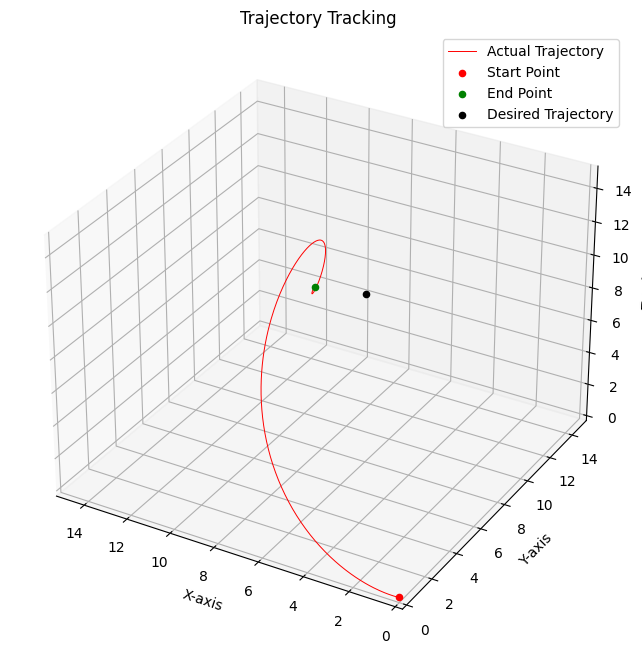

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Actual Trajectory', color='red', linewidth=0.7)
ax.scatter(0, 0, 0, color='red', label='Start Point')
ax.scatter(x[-1], y[-1], z[-1], color='green', label='End Point')
ax.scatter(X_des[0], X_des[1], X_des[2], label='Desired Trajectory', color='black')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectory Tracking')
ax.legend()

ax.set_xlim(15, 0)
ax.set_ylim(0, 15)
ax.set_zlim(0, 15)

plt.show()

### PART 3
Initial position: Quadcopter hovering at the origin <br>
Final position: Quadcopter hovering at the position (x: 6, y: 8, z: 10, yaw: 0) <br>
Wind disturbance: d_wx = 0.15 * sin(pi* t/100) + 0.1 * sin(0.2 *t) + 0.03 * sin(t) m/s^2, d_wy = 0.0 m/s^2, d_wz = 0.0 m/s^2

In [ ]:
##### Initial State
X_curr = Matrix([k, k, k, k, k, k, k, k, k, k, k, k])
U_curr = Matrix([m*g, k, k, k])
U1_dot = k
W_curr = h(X_curr, U_curr, U1_dot)

##### Desired State
X_des = Matrix([[6, 8, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
U_des = Matrix([[m*g], [k], [k], [k]])
W_des = h(X_des, U_des,  U1_dot)

# Generate reference trajectory
Rk = Matrix(np.tile(W_des, (p, 1)))

##### Disturbance Observer
W_do = W_curr # W_do is the state adjusted with the disturbance observer
d_wx, d_wy, d_wz = 0, 0, 0
d_hat = Matrix(zeros(3, 1))

# disturbance_num = np.array(disturbance)
gamma_k = Matrix(zeros(3, 1))
gamma_k_1 = Matrix(zeros(3, 1))
gamma_dot = Matrix(zeros(3, 1))
d_hat = Matrix(zeros(3, 1))

# Optimization variables
Vp = cvx.Variable((4*p,1))
W_p = cvx.Variable((14*p,1))

##### States for plotting
x, y, z = [], [], []
x_do, y_do, z_do = [], [], []
d_x, d_y, d_z = [], [], []
d_wx_applied = []
t = []

iterations = 1000
for i in range(iterations):
  print("i: ", i)

  ############################# PRIMARY COMPUTATION ############################

  ############### OPTIMIZATION ###############
  # Define optimization variables
  W_curr_num = np.array(W_curr)
  W_curr_num.astype('float64')

  # Get the optimized inputs Vk for the given reference trajectory Rk
  J = cvx.quad_form((W_p - Rk), Q) + cvx.quad_form(Vp,F)
  constaints = [W_p == A2_num @ W_curr_num + B2_num @ Vp + Bd_param @ np.array(d_hat * dt),
                Vmin <= Vp,
                Vp <= Vmax]
  opt_prob = cvx.Problem(cvx.Minimize(J),constaints)
  opt_prob.solve()

  # Take the first 4 elements of Vp as our current input Vk
  Vk = Matrix([[float(Vp.value[0])], [float(Vp.value[1])], [float(Vp.value[2])], [float(Vp.value[3])]])
  ####################################################


  ############### DISTURBANCE OBSERVER ###############
  gamma_dot = -L * Bd * (gamma_k_1 + L * W_curr) - L * (A * W_curr + B * Vk)

  d_hat = gamma_k_1 + dt * gamma_dot + L * W_curr

  # Update gamma
  gamma_k_1 = gamma_k
  gamma_k += gamma_dot * dt
  ####################################################


  ############### DISTURBANCE ###############
  # Update the disturbance value
  d_wx = N(0.15*sin(pi * i /100) + 0.1 * sin(0.2 * i) + 0.03 * sin(i))

  disturbance = Matrix([[d_wx],
                        [d_wy],
                        [d_wz]])
  ###########################################


  ############### UPDATE THE MODEL ###############
  # Update our model
  W_curr = Abar * W_curr + Bbar * Vk + Bd * dt * disturbance

  # Get the output matrix
  Y = C * W_curr

  # Update our disturbance observer model
  W_do = W_curr - Bd * dt * d_hat

  # Get the output disturbance observer matrix
  Y_do = C * W_do
  ###############################################


  ##############################################################################

  x.append(Y[0]), y.append(Y[1]), z.append(Y[2])
  x_do.append(Y_do[0]), y_do.append(Y_do[1]), z_do.append(Y_do[2])
  d_x.append(d_hat[0]), d_y.append(d_hat[1]), d_z.append(d_hat[2])
  d_wx_applied.append(d_wx)
  t.append([i*dt])

  #Print values
  # print("Rk: ", Rk)
  # print("W_curr: ", W_curr)
  print("Vk: ", Vk)
  print("gamma_dot: ", gamma_dot)
  print("d_hat: ", d_hat)
  print("Y: ", Y)
  print("Y_do: ", Y_do)
  print("\n")

# Create subplots for position and disturbance
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot for x, y, z in the first column
axs[0, 0].plot(t, x, label="x", linestyle="-.", color="red")
axs[0, 0].plot(t, x_do, label="x_do", linestyle="--", color="darkblue")
axs[0, 0].set_ylabel("X (m)")
axs[0, 0].axhline(y=X_des[0], color='black', label='Reference')
axs[0, 0].legend()
axs[0, 0].grid()

axs[1, 0].plot(t, y, label="y", linestyle="-.", color="red")
axs[1, 0].plot(t, y_do, label="y_do", linestyle="--", color="darkblue")
axs[1, 0].set_ylabel("Y (m)")
axs[1, 0].axhline(y=X_des[1], color='black', label='Reference')
axs[1, 0].legend()
axs[1, 0].grid()

axs[2, 0].plot(t, z, label="z", linestyle="-.", color="red")
axs[2, 0].plot(t, z_do, label="z_do", linestyle="--", color="darkblue")
axs[2, 0].set_ylabel("Z (m)")
axs[2, 0].axhline(y=X_des[2], color='black', label='Reference')
axs[2, 0].legend()
axs[2, 0].grid()

# Plot for d_x, d_y, d_z in the second column
axs[0, 1].plot(t, d_x, color='darkblue', linestyle='--', label="d_x")
axs[0, 1].set_ylabel("X (m/s^2)")
axs[0, 1].plot(t, d_wx_applied, color='red', label='Applied disturbance', linewidth=0.3)
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 1].plot(t, d_y, color='darkblue', linestyle='--', label="d_y")
axs[1, 1].set_ylabel("Y (m/s^2)")
axs[1, 1].axhline(y=d_wy, color='black', label='Applied disturbance')
axs[1, 1].legend()
axs[1, 1].grid()

axs[2, 1].plot(t, d_z, color='darkblue', linestyle='--', label="d_z")
axs[2, 1].set_xlabel("t")
axs[2, 1].set_ylabel("Z (m/s^2)")
axs[2, 1].axhline(y=d_wz, color='black', label='Applied disturbance')
axs[2, 1].legend()
axs[2, 1].grid()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualization of the trajectory

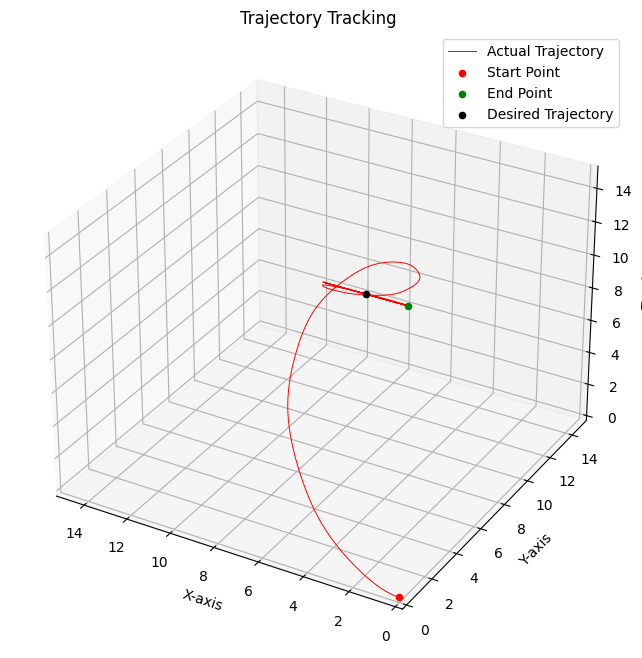

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Actual Trajectory', color='red', linewidth=0.7)
ax.scatter(0, 0, 0, color='red', label='Start Point')
ax.scatter(x[-1], y[-1], z[-1], color='green', label='End Point')
ax.scatter(X_des[0], X_des[1], X_des[2], label='Desired Trajectory', color='black')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectory Tracking')
ax.legend()

ax.set_xlim(15, 0)
ax.set_ylim(0, 15)
ax.set_zlim(0, 15)

plt.show()

## TEST SCENARIO II: TRAJECTORY TRACKING

### Brief Introduction

In this scenario, the desired trajectory is given by: <br>
$$ xd = sin(\pi/10 * t) $$
$$ yd = -1 + cos(\pi/10 * t) $$
$$ zd = t + sin(\pi/10 * t) $$
$$ yawd = atan2(yd, xd) $$

Which can be visualised as below:

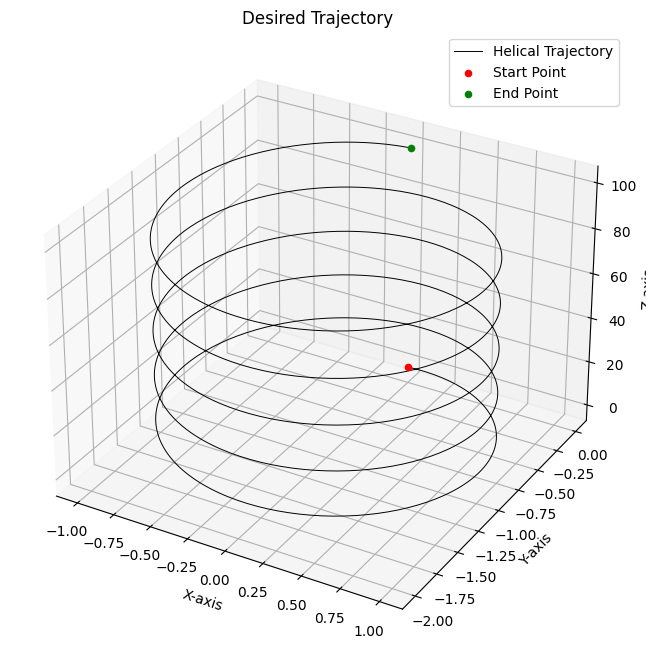

In [ ]:
t = np.linspace(0, 100, 1000)
xd = np.sin(np.pi / 10 * t)
yd = -1 + np.cos(np.pi / 10 * t)
zd = t + np.sin(np.pi / 10 * t)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xd, yd, zd, label='Helical Trajectory', color='black', linewidth=0.7)
ax.scatter(0, 0, 0, color='red', label='Start Point')
ax.scatter(xd[-1], yd[-1], zd[-1], color='green', label='End Point')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Desired Trajectory')
ax.legend()
plt.show()

Part 1 and Part 2 are relevant to the paper used.

### PART 1
Initial position: Quadcopter hovering at the origin <br>
No wind disturbance, ie d_wx = d_wy = d_wz = 0.0 <br>

In [ ]:
##### Initial State
X_curr = Matrix([k, k, k, k, k, k, k, k, k, k, k, k])
U_curr = Matrix([m*g, k, k, k])
U1_dot = k
W_curr = h(X_curr, U_curr, U1_dot)

# Desired State variables
j = 0
time = np.linspace(0, 100, 1000)
xd = np.sin(np.pi / 10 * time[j])
yd = -1 + np.cos(np.pi / 10 * time[j])
zd = time[j] + np.sin(np.pi / 10 * time[j])

##### Disturbance Observer
W_do = W_curr # W_do is the state adjusted with the disturbance observer
d_wx, d_wy, d_wz = 0.0, 0.0, 0.0
d_hat = Matrix(zeros(3, 1))

disturbance = Matrix([[d_wx],
                      [d_wy],
                      [d_wz]])
# disturbance_num = np.array(disturbance)
gamma_k = Matrix(zeros(3, 1))
gamma_k_1 = Matrix(zeros(3, 1))
gamma_dot = Matrix(zeros(3, 1))
d_hat = Matrix(zeros(3, 1))

# Optimization variables
Vp = cvx.Variable((4*p,1))
W_p = cvx.Variable((14*p,1))

##### States for plotting
x, y, z = [], [], []
x_des, y_des, z_des = [], [], []
x_do, y_do, z_do = [], [], []
d_x, d_y, d_z = [], [], []
t = []

iterations = 1000
power = 1
for i in range(iterations):
  print("i: ", i)

  ############################# PRIMARY COMPUTATION ############################

  ########## REFERENCE TRAJECTORY GENERATION ##########

  xd = np.sin(np.pi / 10 * time[i])
  yd = -1 + np.cos(np.pi / 10 * time[i])
  zd = time[i] + np.sin(np.pi / 10 * time[i])
  yawd = math.atan2(yd, xd)

  # Desired State
  X_des = Matrix([[xd, yd, zd, 0, 0, 0, 0, 0, yawd, 0, 0, 0]])
  U_des = Matrix([[m*g], [k], [k], [k]])
  W_des = h(X_des, U_des,  U1_dot)

  # Generate reference trajectory
  Rk = Matrix(np.tile(W_des, (p, 1)))
  #####################################################


  ############### OPTIMIZATION ###############
  # Define optimization variables
  W_curr_num = np.array(W_curr)
  W_curr_num.astype('float64')

  # Get the optimized inputs Vk for the given reference trajectory Rk
  J = cvx.quad_form((W_p - Rk), Q) + cvx.quad_form(Vp,F)
  constaints = [W_p == A2_num @ W_curr_num + B2_num @ Vp + Bd_param @ np.array(d_hat * dt),
                Vmin <= Vp,
                Vp <= Vmax]
  opt_prob = cvx.Problem(cvx.Minimize(J),constaints)
  opt_prob.solve()

  # Take the first 4 elements of Vp as our current input Vk
  Vk = Matrix([[float(Vp.value[0])], [float(Vp.value[1])], [float(Vp.value[2])], [float(Vp.value[3])]])
  ############################################


  ############### DISTURBANCE OBSERVER ###############
  gamma_dot = -L * Bd * (gamma_k_1 + L * W_curr) - L * (A * W_curr + B * Vk)

  d_hat = gamma_k_1 + dt * gamma_dot + L * W_curr

  # Update gamma
  gamma_k_1 = gamma_k
  gamma_k += gamma_dot * dt
  ####################################################


  ############### UPDATE THE MODEL ###############
  # Update our model
  W_curr = Abar * W_curr + Bbar * Vk * power + Bd * dt * disturbance

  # Get the output matrix
  Y = C * W_curr

  # Update our disturbance observer model
  W_do = W_curr - Bd * dt * d_hat

  # Get the output disturbance observer matrix
  Y_do = C * W_do
  ###############################################


  ############### RMSE ERROR CALCULATION ###############
  x_arr, y_arr, z_arr = np.array(x), np.array(y), np.array(z)
  x_des_arr, y_des_arr, z_des_arr = np.array(x_des), np.array(y_des), np.array(z_des)

  # Calculate squared differences
  sq_diff_x, sq_diff_y, sq_diff_z = (x_arr - x_des_arr) ** 2, (y_arr - y_des_arr) ** 2, (z_arr - z_des_arr) ** 2

  # Calculate mean squared errors
  mse_x, mse_y, mse_z = np.mean(sq_diff_x), np.mean(sq_diff_y), np.mean(sq_diff_z)

  # Calculate RMSE by taking the square root of mean squared errors
  rmse_x, rmse_y, rmse_z = mse_x ** 0.5, mse_y ** 0.5, mse_z ** 0.5
  ######################################################


  ##############################################################################

  x.append(Y[0]), y.append(Y[1]), z.append(Y[2])
  x_des.append(xd), y_des.append(yd), z_des.append(zd)
  x_do.append(Y_do[0]), y_do.append(Y_do[1]), z_do.append(Y_do[2])
  d_x.append(d_hat[0]), d_y.append(d_hat[1]), d_z.append(d_hat[2])
  t.append([i*dt])

  #Print values
  # print("Rk: ", Rk)
  # print("W_curr: ", W_curr)
  # print("j: ", j)
  print("(xd, yd, zd, yawd) : ", xd, " ", yd, " ", zd, " ", yawd)
  # print("distance: ", distance)
  # print("Vk: ", Vk)
  # print("d_hat: ", d_hat)
  print("Y: ", Y)
  # print("Y_do: ", Y_do)
  print("RMSE x:", rmse_x)
  print("RMSE y:", rmse_y)
  print("RMSE z:", rmse_z)
  print("\n")

print("#################### SIMULATION COMPLETE ####################")

<ipython-input-159-0fd7f23be812>:31: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  quadcopter_sphere.set_data(data[0, num], data[1, num])
<ipython-input-159-0fd7f23be812>:34: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  reference_sphere.set_data(data1[0, num], data1[1, num])


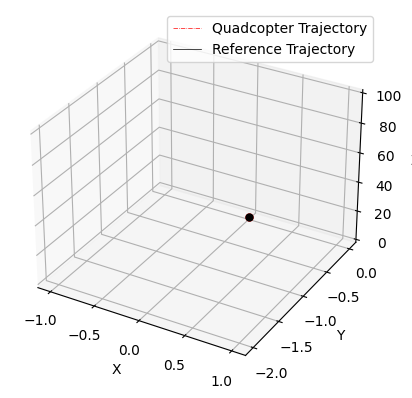

In [ ]:
############### ANIMATOR FUNCTION ###############
from matplotlib import rc
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

##### Define the data to plot
data = np.array([x, y, z])
data1 = np.array([x_des, y_des, z_des])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

N = len(x)
line, = ax.plot(x, y, z, color='red', linestyle='-.', label='Quadcopter Trajectory', linewidth=0.5)
line1, = ax.plot(x_des, y_des, z_des, color='black', label='Reference Trajectory', linewidth=0.5)
# Add spheres for the initial positions
quadcopter_sphere, = ax.plot(x[0], y[0], z[0], 'o', color='red', markersize=5)
reference_sphere, = ax.plot(x_des[0], y_des[0], z_des[0], 'o', color='black', markersize=5)

def update(num, data, data1, line, line1, quadcopter_sphere, reference_sphere):
    # Plot position
    num = num % data.shape[1]
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])
    # Plot trajectory
    line1.set_data(data1[:2, :num])
    line1.set_3d_properties(data1[2, :num])

    # Update sphere positions
    quadcopter_sphere.set_data(data[0, num], data[1, num])
    quadcopter_sphere.set_3d_properties(data[2, num])

    reference_sphere.set_data(data1[0, num], data1[1, num])
    reference_sphere.set_3d_properties(data1[2, num])

    return line, line1, quadcopter_sphere, reference_sphere

# Setting the axes properties
# ax.set_xlim3d([-2.0, 2.0])
ax.set_xlabel('X')

# ax.set_ylim3d([-2.0, 2.0])
ax.set_ylabel('Y')

# ax.set_zlim3d([0.0, 100.0])
ax.set_zlabel('Z')
ax.legend()

ani = FuncAnimation(fig, update, N, fargs=(data, data1, line, line1, quadcopter_sphere, reference_sphere), interval=10000/750, blit=False)
#ani.save('matplot003.gif', writer='imagemagick')
HTML(ani.to_html5_video())

#### Plot the trajectory

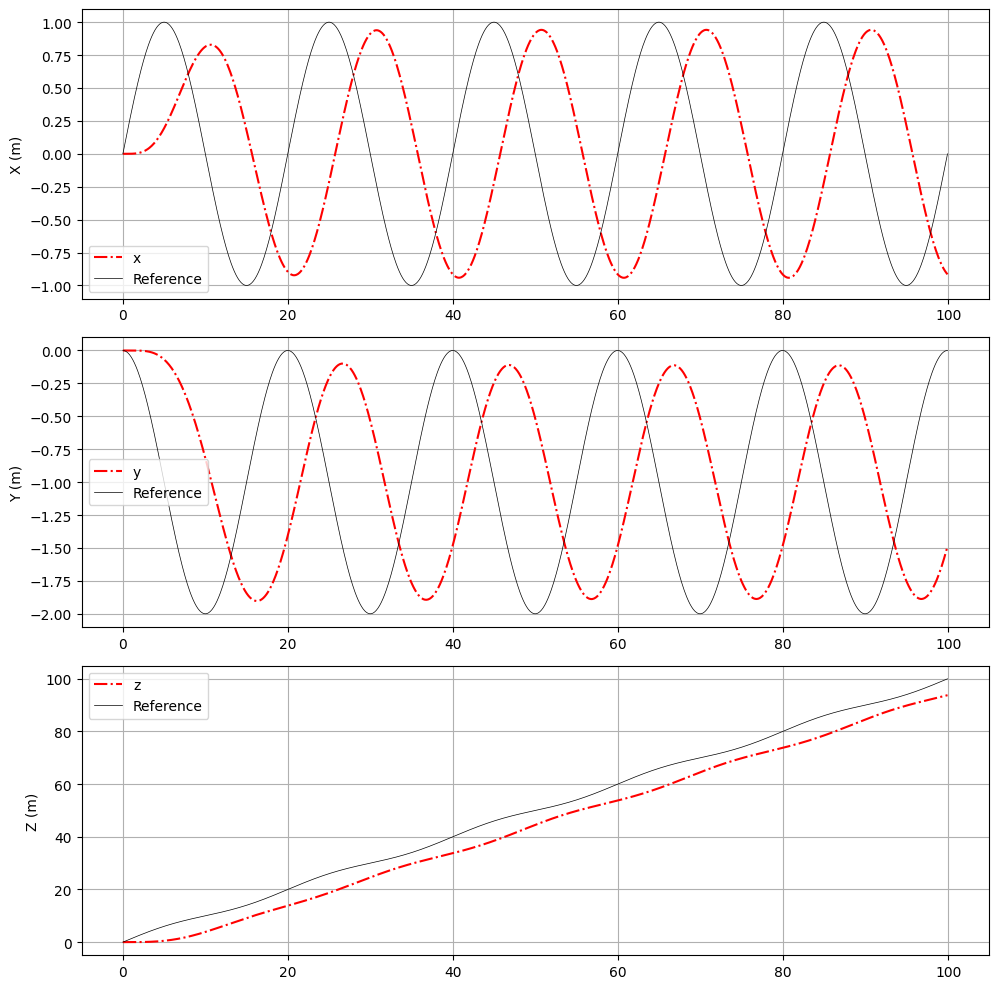

In [ ]:
# Create subplots for position and disturbance
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot for x, y, z in the first column
axs[0].plot(t, x, label="x", linestyle="-.", color="red")
axs[0].set_ylabel("X (m)")
axs[0].plot(t, x_des, color='black', label='Reference', linewidth=0.5)
axs[0].legend()
axs[0].grid()

axs[1].plot(t, y, label="y", linestyle="-.", color="red")
axs[1].set_ylabel("Y (m)")
axs[1].plot(t, y_des, color='black', label='Reference', linewidth=0.5)
axs[1].legend()
axs[1].grid()

axs[2].plot(t, z, label="z", linestyle="-.", color="red")
axs[2].set_ylabel("Z (m)")
axs[2].plot(t, z_des, color='black', label='Reference', linewidth=0.5)
axs[2].legend()
axs[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()

#### Visualization in 3d

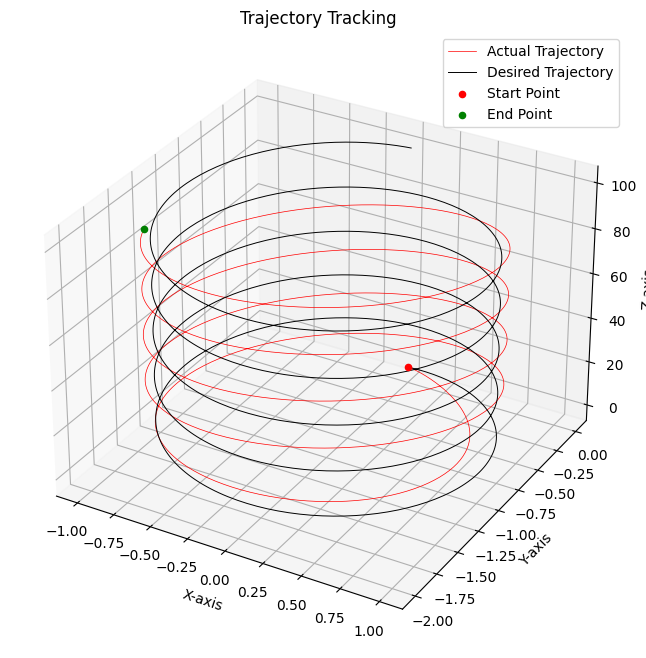

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Actual Trajectory', color='red', linewidth=0.5)
ax.plot(x_des, y_des, z_des, label='Desired Trajectory', color='black', linewidth=0.7)
ax.scatter(0, 0, 0, color='red', label='Start Point')
ax.scatter(x[-1], y[-1], z[-1], color='green', label='End Point')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectory Tracking')
ax.legend()

plt.show()

### PART 2
Initial position: Quadcopter hovering at the origin <br>
Wind disturbance: d_wx = 0.15 * sin(pi* t/100) + 0.1 * sin(0.2 *t) + 0.03 * sin(t) m/s^2, d_wy = -0.08 m/s^2, d_wz = 0.0 m/s^2

In [ ]:
##### Initial State
X_curr = Matrix([k, k, k, k, k, k, k, k, k, k, k, k])
U_curr = Matrix([m*g, k, k, k])
U1_dot = k
W_curr = h(X_curr, U_curr, U1_dot)

# Desired State variables
time = np.linspace(0, 100, 1000)
xd = np.sin(np.pi / 10 * time[j])
yd = -1 + np.cos(np.pi / 10 * time[j])
zd = time[j] + np.sin(np.pi / 10 * time[j])

##### Disturbance Observer
W_do = W_curr # W_do is the state adjusted with the disturbance observer
d_wx, d_wy, d_wz = 0.0, 0.0, 0.0
d_hat = Matrix(zeros(3, 1))

disturbance = Matrix([[d_wx],
                      [d_wy],
                      [d_wz]])
# disturbance_num = np.array(disturbance)
gamma_k = Matrix(zeros(3, 1))
gamma_k_1 = Matrix(zeros(3, 1))
gamma_dot = Matrix(zeros(3, 1))
d_hat = Matrix(zeros(3, 1))

# Optimization variables
Vp = cvx.Variable((4*p,1))
W_p = cvx.Variable((14*p,1))

##### States for plotting
x, y, z = [], [], []
x_des, y_des, z_des = [], [], []
x_do, y_do, z_do = [], [], []
d_x, d_y, d_z = [], [], []
t = []

iterations = 1000
power = 1
for i in range(iterations):
  print("i: ", i)

  ############################# PRIMARY COMPUTATION ############################

  ########## REFERENCE TRAJECTORY GENERATION ##########
  xd = np.sin(np.pi / 10 * time[i])
  yd = -1 + np.cos(np.pi / 10 * time[i])
  zd = time[i] + np.sin(np.pi / 10 * time[i])
  yawd = math.atan2(yd, xd)

  # Desired State
  X_des = Matrix([[xd, yd, zd, 0, 0, 0, 0, 0, yawd, 0, 0, 0]])
  U_des = Matrix([[m*g], [k], [k], [k]])
  W_des = h(X_des, U_des,  U1_dot)

  # Generate reference trajectory
  Rk = Matrix(np.tile(W_des, (p, 1)))
  #####################################################


  ############### OPTIMIZATION ###############
  # Define optimization variables
  W_curr_num = np.array(W_curr)
  W_curr_num.astype('float64')

  # Get the optimized inputs Vk for the given reference trajectory Rk
  J = cvx.quad_form((W_p - Rk), Q) + cvx.quad_form(Vp,F)
  constaints = [W_p == A2_num @ W_curr_num + B2_num @ Vp + Bd_param @ np.array(d_hat * dt),
                Vmin <= Vp,
                Vp <= Vmax]
  opt_prob = cvx.Problem(cvx.Minimize(J),constaints)
  opt_prob.solve()

  # Take the first 4 elements of Vp as our current input Vk
  Vk = Matrix([[float(Vp.value[0])], [float(Vp.value[1])], [float(Vp.value[2])], [float(Vp.value[3])]])
  ############################################


  ############### DISTURBANCE OBSERVER ###############
  gamma_dot = -L * Bd * (gamma_k_1 + L * W_curr) - L * (A * W_curr + B * Vk)

  d_hat = gamma_k_1 + dt * gamma_dot + L * W_curr

  # Update gamma
  gamma_k_1 = gamma_k
  gamma_k += gamma_dot * dt
  ####################################################

  ############### DISTURBANCE ###############
  # Update the disturbance value
  d_wx = N(0.15*sin(pi * i /100) + 0.1*sin(0.2 * i) + 0.03 * sin(i))
  d_wy = -0.08
  disturbance = Matrix([[d_wx],
                        [d_wy],
                        [d_wz]])
  ###########################################


  ############### UPDATE THE MODEL ###############
  # Update our model
  W_curr = Abar * W_curr + Bbar * Vk * power + Bd * dt * disturbance

  # Get the output matrix
  Y = C * W_curr

  # Update our disturbance observer model
  W_do = W_curr - Bd * dt * d_hat

  # Get the output disturbance observer matrix
  Y_do = C * W_do
  ###############################################


  ############### RMSE ERROR CALCULATION ###############
  x_arr, y_arr, z_arr = np.array(x), np.array(y), np.array(z)
  x_des_arr, y_des_arr, z_des_arr = np.array(x_des), np.array(y_des), np.array(z_des)

  # Calculate squared differences
  sq_diff_x, sq_diff_y, sq_diff_z = (x_arr - x_des_arr)**2, (y_arr - y_des_arr)**2, (z_arr - z_des_arr)**2

  # Calculate mean squared errors
  mse_x, mse_y, mse_z = np.mean(sq_diff_x), np.mean(sq_diff_y), np.mean(sq_diff_z)

  # Calculate RMSE by taking the square root of mean squared errors
  rmse_x, rmse_y, rmse_z = mse_x ** 0.5, mse_y ** 0.5, mse_z ** 0.5
  ######################################################


  ##############################################################################

  x.append(Y[0]), y.append(Y[1]), z.append(Y[2])
  x_des.append(xd), y_des.append(yd), z_des.append(zd)
  x_do.append(Y_do[0]), y_do.append(Y_do[1]), z_do.append(Y_do[2])
  d_x.append(d_hat[0]), d_y.append(d_hat[1]), d_z.append(d_hat[2])
  t.append([i*dt])

  #Print values
  # print("Rk: ", Rk)
  # print("W_curr: ", W_curr)
  # print("j: ", j)
  print("(xd, yd, zd, yawd) : ", xd, " ", yd, " ", zd, " ", yawd)
  # print("distance: ", distance)
  # print("Vk: ", Vk)
  print("d_hat: ", d_hat)
  print("Y: ", Y)
  # print("Y_do: ", Y_do)
  print("RMSE x:", rmse_x)
  print("RMSE y:", rmse_y)
  print("RMSE z:", rmse_z)
  print("\n")

print("#################### SIMULATION COMPLETE ####################")

#### Plot the trajectory

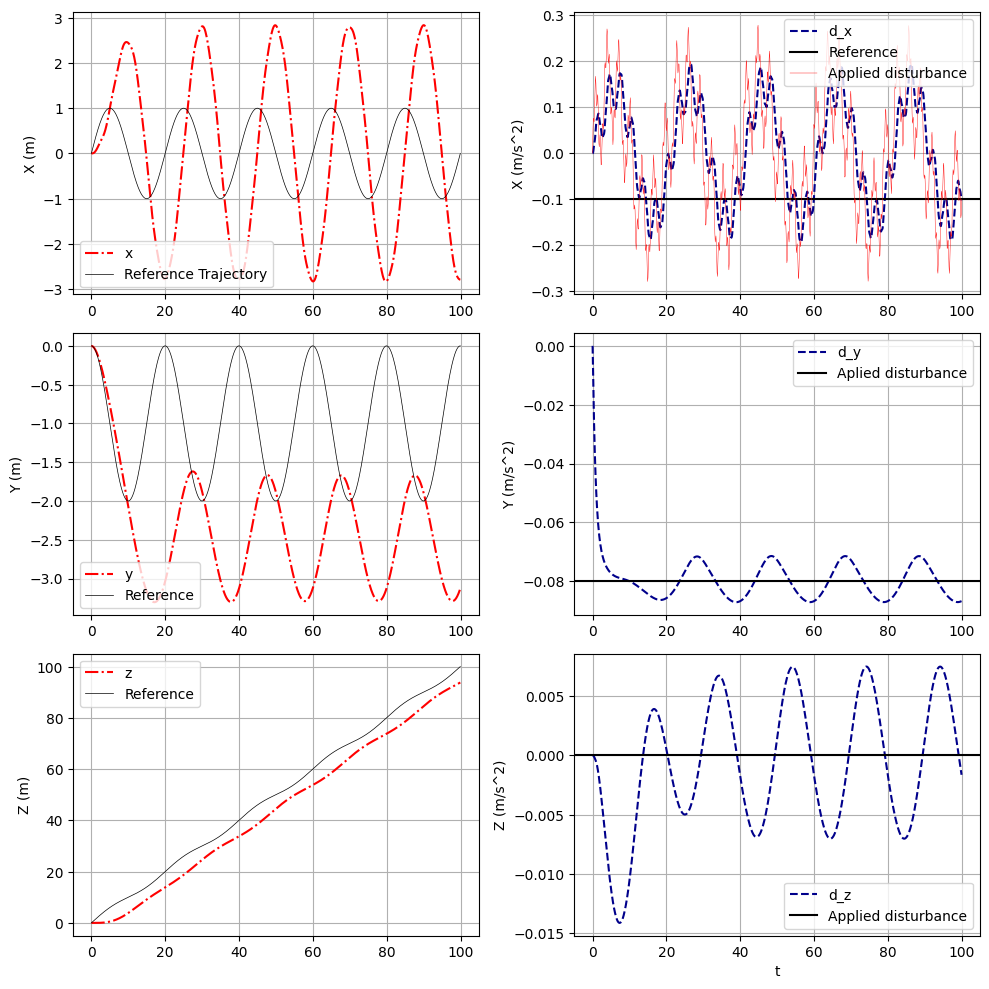

In [ ]:
# Create subplots for position and disturbance
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot for x, y, z in the first column
axs[0, 0].plot(t, x, label="x", linestyle="-.", color="red")
axs[0, 0].plot(t, x_des, color='black', label='Reference Trajectory', linewidth=0.5)
axs[0, 0].set_ylabel("X (m)")
axs[0, 0].legend()
axs[0, 0].grid()

axs[1, 0].plot(t, y, label="y", linestyle="-.", color="red")
axs[1, 0].plot(t, y_des, color='black', label='Reference', linewidth=0.5)
axs[1, 0].set_ylabel("Y (m)")
axs[1, 0].legend()
axs[1, 0].grid()

axs[2, 0].plot(t, z, label="z", linestyle="-.", color="red")
axs[2, 0].plot(t, z_des, color='black', label='Reference', linewidth=0.5)
axs[2, 0].set_ylabel("Z (m)")
axs[2, 0].legend()
axs[2, 0].grid()

# Plot for d_x, d_y, d_z in the second column
axs[0, 1].plot(t, d_x, color='darkblue', linestyle='--', label="d_x")
axs[0, 1].set_ylabel("X (m/s^2)")
axs[0, 1].axhline(y=d_wx, color='black', label='Reference')
axs[0, 1].plot(t, d_wx_applied, color='red', label='Applied disturbance', linewidth=0.3)
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 1].plot(t, d_y, color='darkblue', linestyle='--', label="d_y")
axs[1, 1].set_ylabel("Y (m/s^2)")
axs[1, 1].axhline(y=d_wy, color='black', label='Aplied disturbance')
axs[1, 1].legend()
axs[1, 1].grid()

axs[2, 1].plot(t, d_z, color='darkblue', linestyle='--', label="d_z")
axs[2, 1].set_xlabel("t")
axs[2, 1].set_ylabel("Z (m/s^2)")
axs[2, 1].axhline(y=d_wz, color='black', label='Applied disturbance')
axs[2, 1].legend()
axs[2, 1].grid()

plt.tight_layout()
plt.show()

#### Visualization in 3d

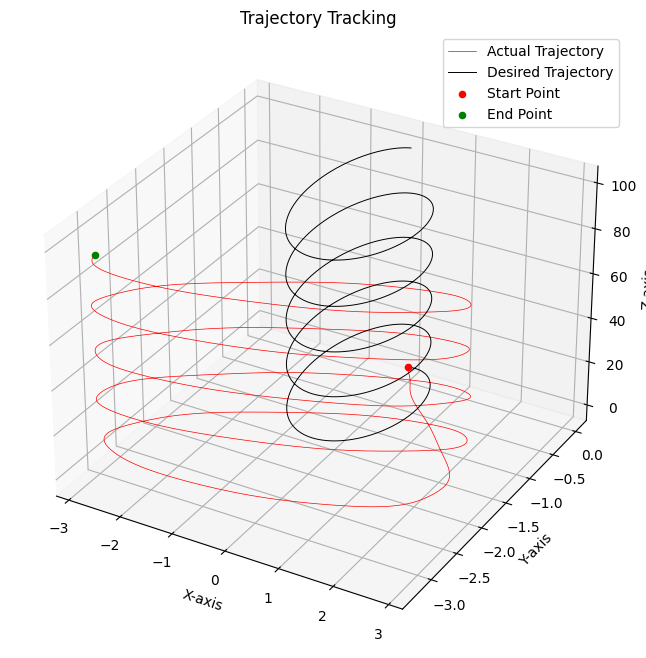

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Actual Trajectory', color='red', linewidth=0.5)
ax.plot(x_des, y_des, z_des, label='Desired Trajectory', color='black', linewidth=0.7)
ax.scatter(0, 0, 0, color='red', label='Start Point')
ax.scatter(x[-1], y[-1], z[-1], color='green', label='End Point')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectory Tracking')
ax.legend()

plt.show()